In [1]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
from PDBClean import pdbclean_io, pdbutils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Summary of PDB dataset 

## What is the goal of this notebook?


This notebook creates a summary of the basic features of a structure dataset. It takes as input the 'raw_bank' directory created during step 0. Users need to create a 'pdblist.txt' with the list of CIFs that will be included in the summary. Users also need to specify the directories where the CIFs are stored, and the directory where the created files will be stored. 

In the first step, a pandas dataframe is populated with the info read from the CIFs. The info in the dataframe is then written as a csv file. 

In a second step, we create an image with the plots summarizing the data in the dataframe. Four plots are included, a boxplot of the resolution of the structures, a histogram of the year in which the structures were published, a histogram of the methods used to solve the structures, and a histogram of the organism of origin of the molecule in the structure. The image with the four plots is saved as a pdf. 

## How to create the 'pdblist.txt'

This notebook uses 'pdblist.txt' which is derived from the files in the 'raw_bank'. To create the 'pdblist.txt' run this line within the terminal **in the 'raw_bank' directory**: 

>ls | grep cif > pdblist.txt




## Define functions

In [2]:
def make_pdb_df(trajdir, readdir, trajlist):

    pdbids=[]
    orgalist=[]
    resolution=[]
    year=[]
    method=[]

    trajitas=open(trajdir+trajlist,'r')
    trajitas=trajitas.readlines()


    for item in range(0,len(trajitas)):
        pdbid=trajitas[item].strip()
        pdbid=pdbid[0:4]
        pdbids.append(pdbid)

        #pdbutils.download_pdb_from_id(oldfile, download_dir=readdir)

        mmcif_dict = MMCIF2Dict(readdir+pdbid+".cif")

        # find organism
        if '_em_entity_assembly_naturalsource.organism' in mmcif_dict:
            organism=mmcif_dict['_em_entity_assembly_naturalsource.organism'][0]
            split_word = organism.split()
            if len(split_word) > 1:
                orgalist.append(' '.join(split_word[0:2]).upper())
            else:
                orgalist.append(' '.join(split_word[0:1]).upper())
          
        elif '_entity_src_nat.pdbx_organism_scientific' in mmcif_dict:
       
            organism=mmcif_dict['_entity_src_nat.pdbx_organism_scientific'][0]
            split_word = organism.split()
            if len(split_word) > 1:
                orgalist.append(' '.join(split_word[0:2]).upper())
            else:
                orgalist.append(' '.join(split_word[0:1]).upper())
        elif '_entity_src_gen.pdbx_gene_src_scientific_name' in mmcif_dict:
          
            organism=mmcif_dict['_entity_src_gen.pdbx_gene_src_scientific_name'][0]
            split_word = organism.split()
            if len(split_word) > 1:
                orgalist.append(' '.join(split_word[0:2]).upper())
            else:
                orgalist.append(' '.join(split_word[0:1]).upper())
        else:
            orgalist.append('')

        #find resolution
        if '_reflns.d_resolution_high' in mmcif_dict:
            if mmcif_dict['_reflns.d_resolution_high'][0] != '?':
                resolution.append(float(mmcif_dict['_reflns.d_resolution_high'][0]))
            elif '_em_3d_reconstruction.resolution' in mmcif_dict and (mmcif_dict['_em_3d_reconstruction.resolution'][0] != '?'):
                resolution.append(float(mmcif_dict['_em_3d_reconstruction.resolution'][0]))
            elif '_refine.ls_d_res_high' in mmcif_dict and (mmcif_dict['_refine.ls_d_res_high'][0] != '?'):
                resolution.append(float(mmcif_dict['_refine.ls_d_res_high'][0]))
            else:
                resolution.append(0)
        elif '_em_3d_reconstruction.resolution' in mmcif_dict:
            if mmcif_dict['_em_3d_reconstruction.resolution'][0] != '?':
                resolution.append(float(mmcif_dict['_em_3d_reconstruction.resolution'][0]))
            elif '_refine.ls_d_res_high' in mmcif_dict and (mmcif_dict['_refine.ls_d_res_high'][0] != '?'):
                resolution.append(float(mmcif_dict['_refine.ls_d_res_high'][0]))
            else:
                resolution.append(0)
        elif '_refine.ls_d_res_high' in mmcif_dict and (mmcif_dict['_refine.ls_d_res_high'][0] != '?'):
                resolution.append(float(mmcif_dict['_refine.ls_d_res_high'][0]))
        else:
            resolution.append(0)

        #find year of publication

        if '_citation.year' in mmcif_dict:
            if mmcif_dict['_citation.year'][0] == '?' or mmcif_dict['_citation.year'][0] == '.':
                if '_pdbx_database_status.recvd_initial_deposition_date'in mmcif_dict:
                    year.append(int(mmcif_dict['_pdbx_database_status.recvd_initial_deposition_date'][0][0:4]))
                else:
                    year.append()
            else:
                year.append(int(mmcif_dict['_citation.year'][0]))
        else:
            year.append()  
        
        
        #find method
        
        if '_exptl.method' in mmcif_dict:
            method.append(mmcif_dict['_exptl.method'][0])
        else:
            method.append('')
            
            
        print(pdbids[item], orgalist[item], resolution[item], year[item],method[item])
        ##print(pdbids[item],year[item])


    df = pd.DataFrame(list(zip(pdbids, orgalist,resolution,year,method)),
                   columns =['PDBid', 'Organism', 'Resolution (Å)','Year','Method'])

    
    return(df)
    
    #print(oldfile, orgalist)



In [3]:
def summary_plots_pdbs(df, outdir, organism):
    '''
    df: dataframe with summary info of pdb dataset
    outdir: directory where plots will be stored'''

    f = plt.figure(figsize=(32, 48))
    gs = f.add_gridspec(2, 2)
    fs = 40

    #PLOT RESOLUTION
    ax = f.add_subplot(gs[0, 0])
    #sns.boxplot(df['Resolution']).set(title="Resolution (Å)")
    #sns.boxplot(df[df['Resolution'].str.match('N/A')==False]['Resolution'])#.set(title="Resolution (Å)")
    sns.histplot(df['Resolution (Å)']) #.set(title="Resolution (Å)")
    plt.yticks(fontsize=fs)
    plt.xticks(fontsize=fs)
    #plt.title('Resolution (Å)', fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
    
    #PLOT YEAR
    ax = f.add_subplot(gs[0, 1])
    sortdf=df.sort_values(by="Year",ascending=True)
    plot=sns.histplot(sortdf['Year'])#.set(title="Year of Publication")
    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation=30, ha="right")#, fontsize = 'x-small')
    plt.yticks(fontsize=fs)
    plt.xticks(fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)


    print("x-axis tick locations: " + str(xtick_loc))
    
    #PLOT METHOD
    
    ax = f.add_subplot(gs[1, 0])
    
    plot = sns.histplot(df['Method'])

        # Get x-axis tick locations and labels

    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation=30, ha="right")#, fontsize = 'x-small')
    plt.yticks(fontsize=fs)
    plt.xticks(fontsize=fs-20)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    
    
    
    #PLOT ORGANISM
    ax = f.add_subplot(gs[1, 1])
    sortdf=df['Organism'].value_counts(ascending=False).rename_axis('Organism').rename('count')
    plot = sns.barplot(x=sortdf.index, y=sortdf.values, order=sortdf.index)

        # Get x-axis tick locations and labels

    xtick_loc = plot.get_xticks()
    xtick_labels = plot.get_xticklabels()

        # Set the x-axis ticks

    plt.setp(xtick_labels, rotation=30, ha="right", fontsize = 'x-small')
    
    
    plt.subplots_adjust(bottom=0.4)
    plt.yticks(fontsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)


    print("x-axis tick locations: " + str(xtick_loc))


    plt.savefig(outdir+'/'+organism+"_summary_plots.pdf")


## Specify working directories

In [4]:
# TIM
PROJDIR = './TIM/'
readdir= PROJDIR + '/raw_bank/'
trajdir=readdir
trajlist="./pdblist.txt"
outdir= PROJDIR + '/SUMMARY/'
org_name='tim'



In [5]:
pdbclean_io.check_project(projdir=PROJDIR, level='SUMMARY')

## Run functions

1. Populate dataframe with basic info of each structure: 'PDBid', 'Organism', 'Resolution','Year', 'Method' 
2. Create plots with summary of the basic info. 


In [6]:
# Populate dataframe
# Funcion prints items to screen
df=make_pdb_df(trajdir, readdir, trajlist)

1ag1 TRYPANOSOMA BRUCEI 2.36 1991 X-RAY DIFFRACTION
1aw1 MORITELLA MARINA 2.7 1998 X-RAY DIFFRACTION
1aw2 MORITELLA MARINA 2.65 1998 X-RAY DIFFRACTION
1b9b THERMOTOGA MARITIMA 2.85 1999 X-RAY DIFFRACTION
1btm GEOBACILLUS STEAROTHERMOPHILUS 2.8 1995 X-RAY DIFFRACTION
1ci1 TRYPANOSOMA CRUZI 1.95 1999 X-RAY DIFFRACTION
1dkw TRYPANOSOMA BRUCEI 2.6 2001 X-RAY DIFFRACTION
1hg3 PYROCOCCUS WOESEI 3.0 2001 X-RAY DIFFRACTION
1hti HOMO SAPIENS 2.8 1994 X-RAY DIFFRACTION
1i45 SACCHAROMYCES CEREVISIAE 1.8 2001 X-RAY DIFFRACTION
1if2 LEISHMANIA MEXICANA 2.0 2001 X-RAY DIFFRACTION
1iig TRYPANOSOMA BRUCEI 2.6 1991 X-RAY DIFFRACTION
1iih TRYPANOSOMA BRUCEI 2.2 1991 X-RAY DIFFRACTION
1klg HOMO SAPIENS 1.93 2002 X-RAY DIFFRACTION
1klu HOMO SAPIENS 1.93 2002 X-RAY DIFFRACTION
1kv5 TRYPANOSOMA BRUCEI 1.65 2002 X-RAY DIFFRACTION
1lyx PLASMODIUM FALCIPARUM 1.9 2002 X-RAY DIFFRACTION
1lzo PLASMODIUM FALCIPARUM 2.8 2002 X-RAY DIFFRACTION
1m6j ENTAMOEBA HISTOLYTICA 1.5 2002 X-RAY DIFFRACTION
1m7o PLASMODIUM FAL

4rcx TRICHOMONAS VAGINALIS 1.75 2014 X-RAY DIFFRACTION
4tim TRYPANOSOMA BRUCEI 2.4 1991 X-RAY DIFFRACTION
4unk HOMO SAPIENS 2.0 2014 X-RAY DIFFRACTION
4unl HOMO SAPIENS 1.5 2014 X-RAY DIFFRACTION
4wje TRICHOMONAS VAGINALIS 1.285 2014 X-RAY DIFFRACTION
4x22 LEPTOSPIRA INTERROGANS 2.084 2016 X-RAY DIFFRACTION
4y8f CLOSTRIDIUM PERFRINGENS 1.54 2015 X-RAY DIFFRACTION
4y90 DEINOCOCCUS RADIODURANS 2.1 2015 X-RAY DIFFRACTION
4y96 GEMMATA OBSCURIGLOBUS 1.58 2015 X-RAY DIFFRACTION
4y9a STREPTOMYCES COELICOLOR 2.29 2015 X-RAY DIFFRACTION
4ymz LEPTOSPIRA INTERROGANS 1.87 2016 X-RAY DIFFRACTION
4ywi PLASMODIUM FALCIPARUM 1.85 2016 X-RAY DIFFRACTION
4yxg PLASMODIUM FALCIPARUM 1.9 2016 X-RAY DIFFRACTION
4z0j PLASMODIUM FALCIPARUM 2.07 2016 X-RAY DIFFRACTION
4z0s PLASMODIUM FALCIPARUM 2.36 2016 X-RAY DIFFRACTION
4zvj HOMO SAPIENS 1.6996 2015 X-RAY DIFFRACTION
4zz9 PLASMODIUM FALCIPARUM 1.805 2015 X-RAY DIFFRACTION
5bmw PLASMODIUM FALCIPARUM 1.859 2015 X-RAY DIFFRACTION
5bmx PLASMODIUM FALCIPARUM 1.8 

In [7]:
# Write dataframe as CSV file 

df.to_csv(outdir+org_name+'.csv')

x-axis tick locations: [1970. 1980. 1990. 2000. 2010. 2020. 2030.]
x-axis tick locations: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


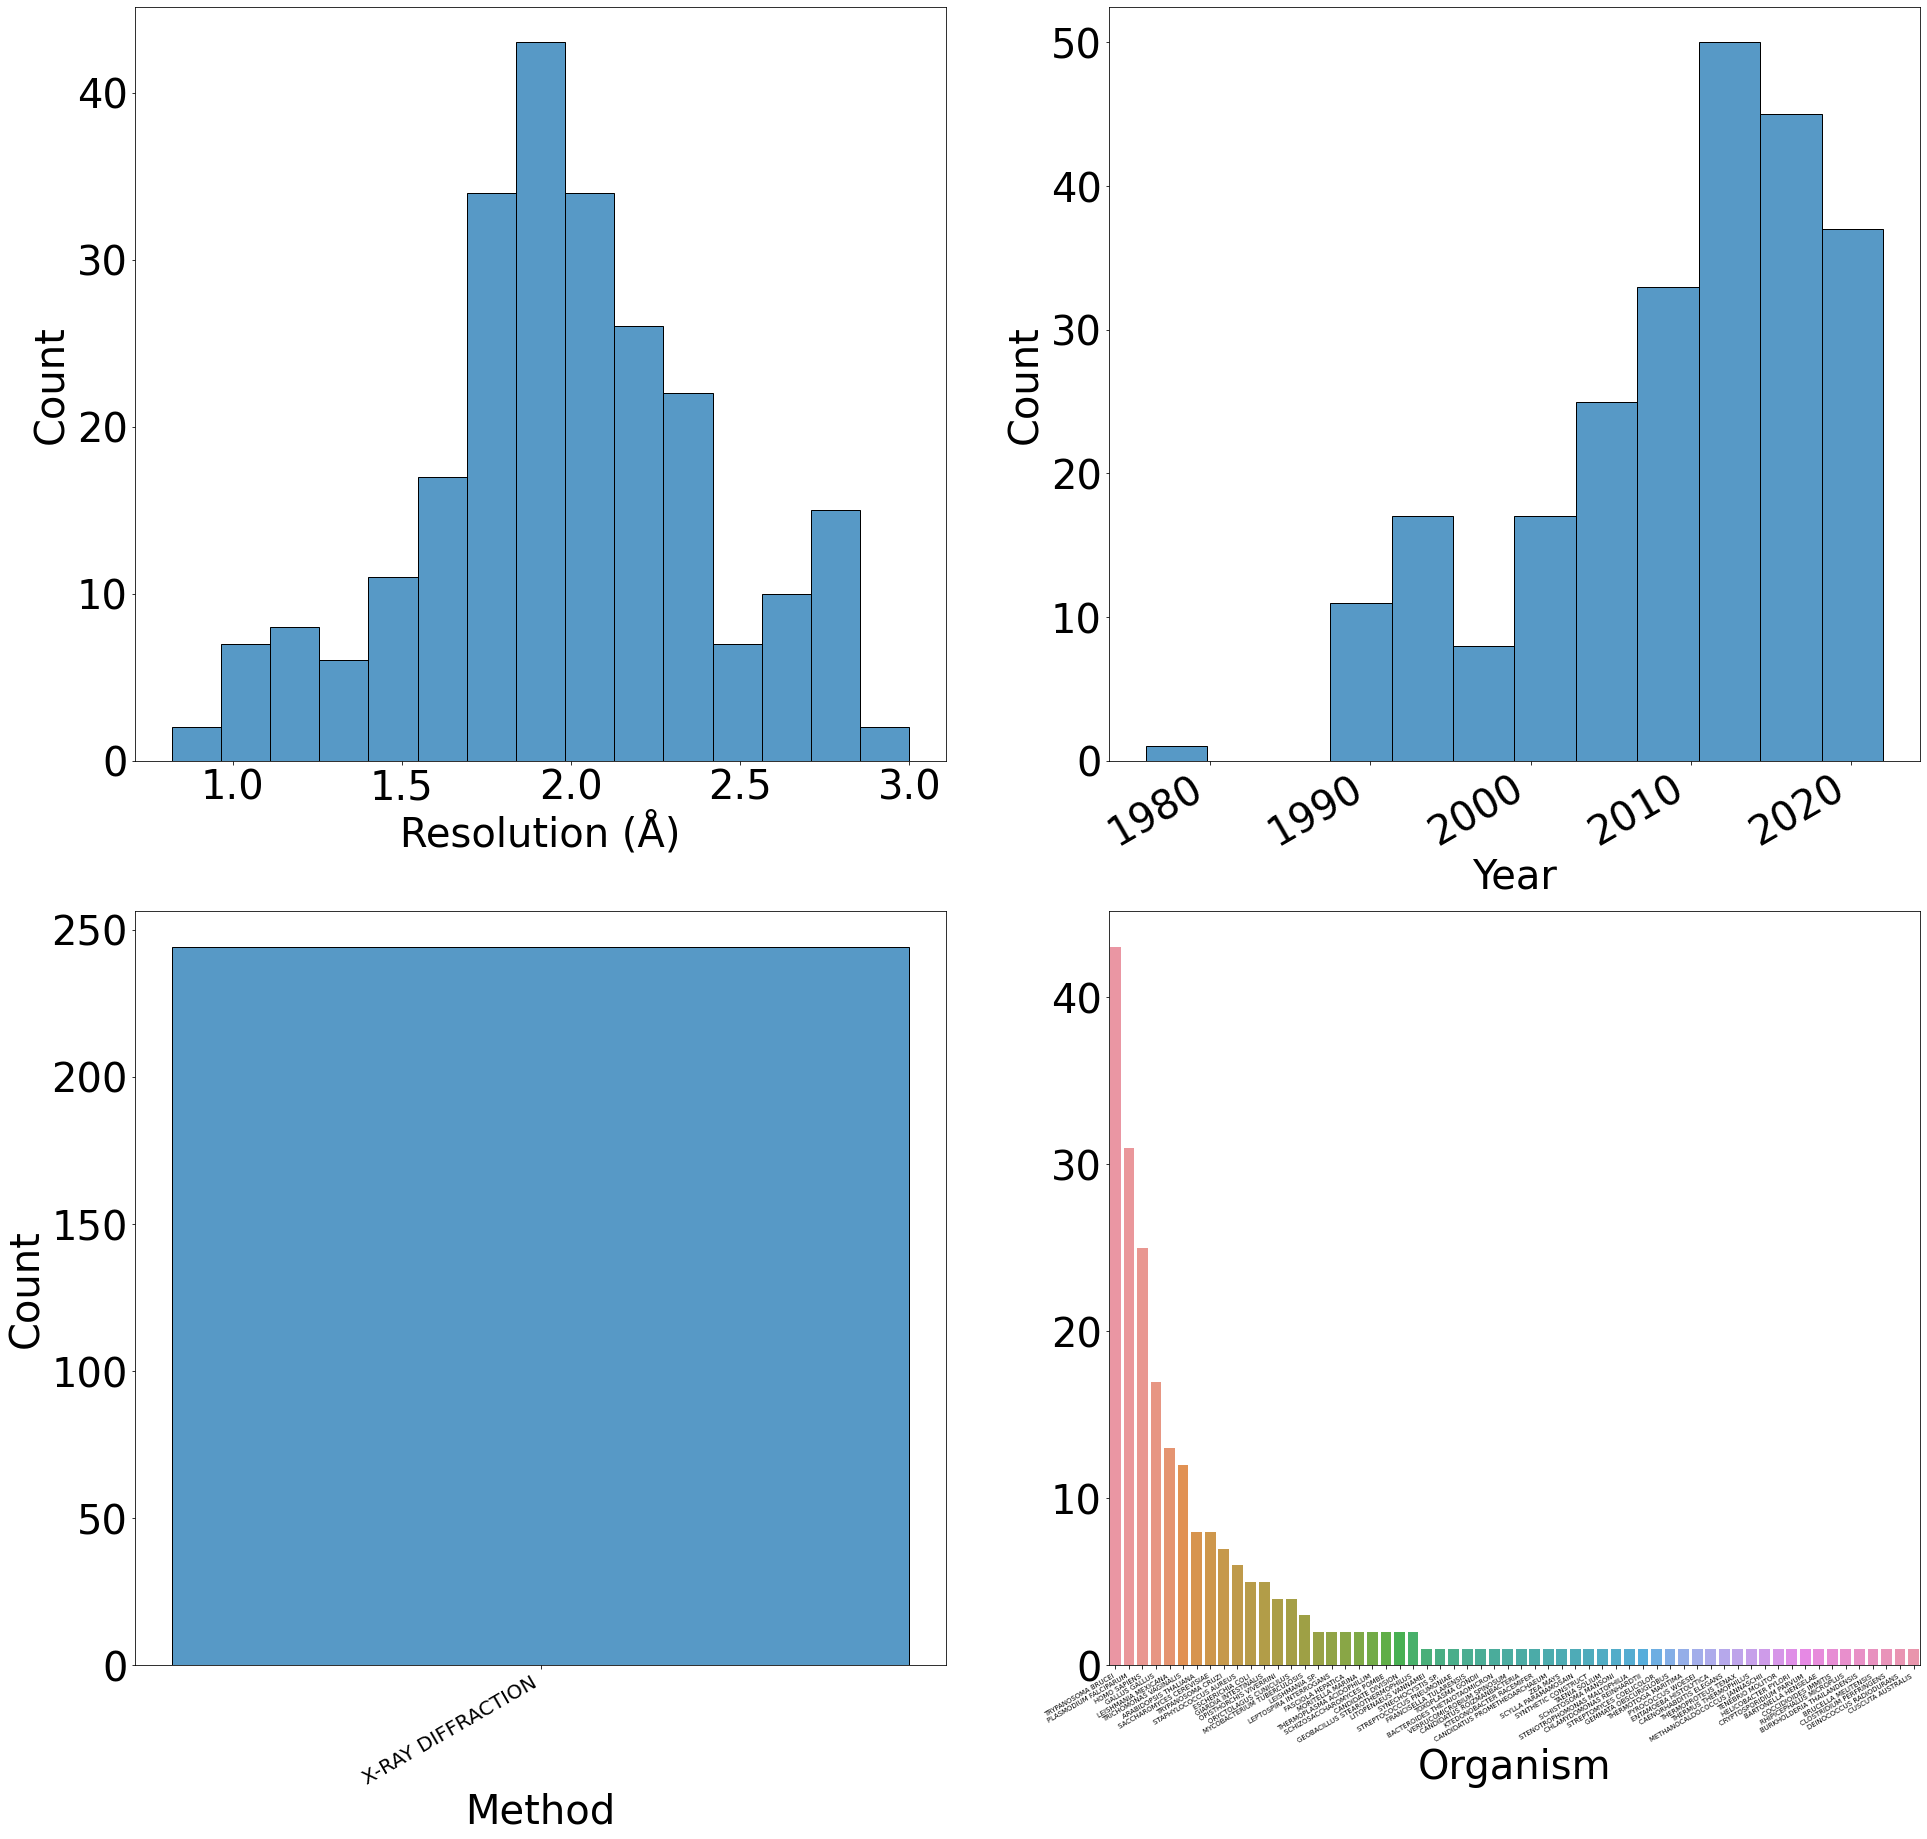

In [8]:
# Create images with the plots summarizing the info in the dataframe

summary_plots_pdbs(df, outdir,org_name)